To determine the particle's orbit, the second-order ODE for the trajectory is solved numerically using a Runge-Kutta method by converting the equation for a massive particle,
\begin{equation}
    \frac{d^2u}{d\phi^2} + u = \frac{1}{2h^2} + \frac{3u^2}{2}
\end{equation}
into a system of two first-order equations. Let $y_1 = u$ and $y_2 = \frac{du}{d\phi}$. Then
\begin{equation}
    \begin{cases}
        \frac{dy_1}{d\phi} = y_2 \\
        \frac{dy_2}{d\phi} = \frac{1}{2h^2} + \frac{3y_1^2}{2} - y_1
    \end{cases}
\end{equation}
We then integrate for various angular momentum parameters $h$. The angular momentum $h$ is varied from $0$ (radial infall to the event horizon at $r = 1$) up to the value required for a stable circular orbit. We can compute the expected momentum required for a circular orbit by setting $\frac{du}{d\phi} = \frac{d^2u}{d\phi^2} = 0$,
\begin{equation}
    u = \frac{1}{2h^2} + \frac{3u^2}{2} \implies h = (u(2 - 3u))^{-1/2}.
\end{equation}
A numerical search can be performed to find the critical angular momentum $h^*$ that separates capture trajectories from stable orbits. The proper time $\tau$, which is the time experienced by the falling particle, is calculated by integrating the proper time element along the trajectory. The shortest possible time to fall into the black hole occurs with zero angular momentum. The proper time approaches infinity as the momentum approaches $h^*$.

In [115]:
import numpy as np
from scipy.integrate import solve_ivp, quad
import matplotlib.pyplot as plt

def orbit_ode(phi, y, h_sq):
    '''
    Defines the system of first-order ordinary differential equations for the orbit.
    Args:
        phi: The current angle (independent variable).
        y: A list [u, du_dphi] where u = 1/r.
        h_sq: The square of the angular momentum parameter.
    Returns:
        The derivatives [dy1/dphi, dy2/dphi].
    '''
    u, du_dphi = y
    # The equation is d^2u/dphi^2 = 1/(2h^2) + (3/2)u^2 - u
    d2u_dphi2 = 1.0 / (2.0 * h_sq) + 1.5 * u**2 - u
    return [du_dphi, d2u_dphi2]

def capture_event(phi, y, h_sq):
    '''
    An event function for solve_ivp to detect when the particle is captured (r=1 or u=1).
    '''
    return y[0] - 1.0  # Event triggers when u(phi) - 1 = 0

capture_event.terminal = True  # Stop integration when the event occurs
capture_event.direction = 1    # Trigger only when u is increasing towards 1

def get_circular_h(r_orbit):
    '''
    Calculates the angular momentum 'h' for a stable circular orbit at radius r.
    '''
    u_orbit = 1.0 / r_orbit
    h_sq = 1.0 / (2 * (u_orbit - 1.5 * u_orbit**2))
    return np.sqrt(h_sq)

def find_critical_h(r_initial, search_range=(1.7, 1.8), resolution=101):
    '''
    Finds the critical angular momentum that separates capture orbits from stable ones.
    Returns:
        The approximate critical angular momentum, h_crit.
    '''
    h_test_values = np.linspace(search_range[0], search_range[1], resolution)
    h_crit = 0

    y_initial = [1.0/r_initial, 0]
    phi_span = [0, 50.0] # A sufficiently large integration range

    for h in h_test_values:
        sol = solve_ivp(orbit_ode, phi_span, y_initial, args=(h**2,), events=capture_event, rtol=1e-8)
        # If the integration was stopped by our capture event, it's a capture orbit
        if sol.t_events[0].size > 0:
            h_crit = h  # Store the highest h value that still results in capture
    return h_crit

def calculate_proper_time_for_infall(r_initial, h_values):
    '''
    Calculates the proper time for a particle to fall from r_initial to r=1.
    Args:
        r_initial: The starting radius.
        h_values: An array of angular momenta in the capture range.
    Returns:
        A list of calculated proper times corresponding to each h.
    '''

    def integrand(r, h_sq):
        '''
        The function d(tau)/dr to be integrated.
        '''
        E_sq = (1.0 - 1.0 / r_initial) * (1.0 + h_sq / r_initial**2)
        potential_term = E_sq - (1.0 - 1.0 / r) * (1.0 + h_sq / r**2)
        if potential_term < 1e-12: # Avoid numerical errors near zero
            return 0
        return 1.0 / np.sqrt(potential_term)

    proper_times = []
    for h in h_values:
        time, error = quad(integrand, 1.0, r_initial, args=(h**2,))
        proper_times.append(time)

    return proper_times

In [116]:
def plot_orbits(r_initial, h_values_to_plot):
    '''
    Generates and displays a polar plot of particle orbits.
    '''
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})
    ax.set_title(f'Particle Orbits for r(0)={r_initial}', loc='right')

    # Plot the event horizon
    phi_grid = np.linspace(0, 2 * np.pi, 100)
    ax.plot(phi_grid, np.ones_like(phi_grid), 'k-', linewidth=3, label='Event Horizon (r=1)')

    y_initial = [1.0 / r_initial, 0]
    phi_span = [0, 50.0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(h_values_to_plot)))

    for h, color in zip(h_values_to_plot, colors):
        label = f'h = {h:.3f}'
        if h == 0:
            r, phi = np.linspace(r_initial, 1, 100), np.zeros(100)
            label += ' (Radial Infall)'
        else:
            sol = solve_ivp(
                orbit_ode, phi_span, y_initial, args=(h**2,),
                dense_output=True, events=capture_event, rtol=1e-8, atol=1e-10
            )
            phi = np.linspace(phi_span[0], sol.t[-1], 500)
            r = 1.0 / sol.sol(phi)[0]

        ax.plot(phi, r, color=color, label=label)

    ax.set_rmax(r_initial + 1)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()

def plot_proper_time(h_values, proper_times, h_crit):
    '''
    Generates and displays a plot of proper time vs. angular momentum.
    '''
    plt.figure(figsize=(8, 5))
    plt.plot(h_values, proper_times, 'b-', label='Calculated Proper Time')
    plt.axvline(h_crit, color='r', linestyle='--', label=f'Critical h ≈ {h_crit:.4f}')
    plt.xlabel('Angular Momentum Parameter (h)')
    plt.ylabel('Proper Time for Infall (τ)')
    plt.title('Proper Time to Fall from r=6 to r=1')
    plt.grid(True)
    plt.legend()
    plt.show()

Angular momentum for a circular orbit at r=6.0: h = 2.0000



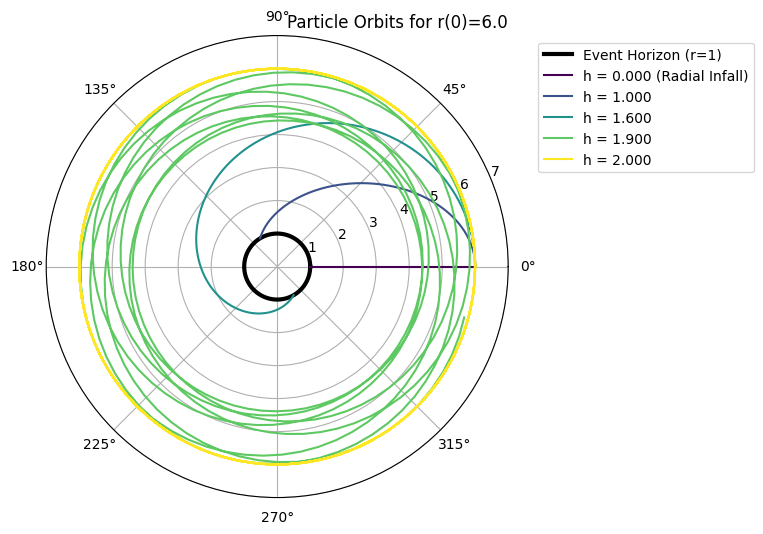

The critical angular momentum is approximately h_crit ≈ 1.7800
Proper time for radial infall (h=0): τ ≈ 22.3826


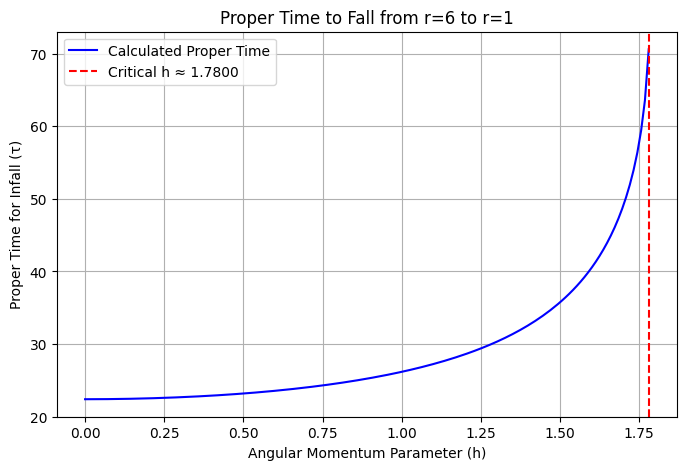

In [117]:
r_start = 6.0
h_circ = get_circular_h(r_start)
print(f"Angular momentum for a circular orbit at r={r_start}: h = {h_circ:.4f}\n")
h_to_plot = [0, 1.0, 1.6, 1.9, h_circ]
plot_orbits(r_start, h_to_plot)

h_critical = find_critical_h(r_start, search_range=(1.0, h_circ))
print(f"The critical angular momentum is approximately h_crit ≈ {h_critical:.4f}")

h_infall_range = np.linspace(0, h_critical, 150)
times = calculate_proper_time_for_infall(r_start, h_infall_range)
print(f"Proper time for radial infall (h=0): τ ≈ {times[0]:.4f}")
plot_proper_time(h_infall_range, times, h_critical)

For a massive particle in the Schwarzschild metric, there is a critical radius known as the innermost stable circular orbit, which is located at $r=3$. Outside this radius, stable circular orbits are possible. A particle can orbit indefinitely, and if perturbed slightly, it will oscillate around its stable radius. Inside this radius, no stable circular orbits exist. While it is theoretically possible to have an unstable circular orbit for a specific angular momentum, any tiny perturbation (or numerical error in a simulation) will cause the particle to eventually fall into the black hole.

Angular momentum for a circular orbit at r=2.5: h = 1.7678



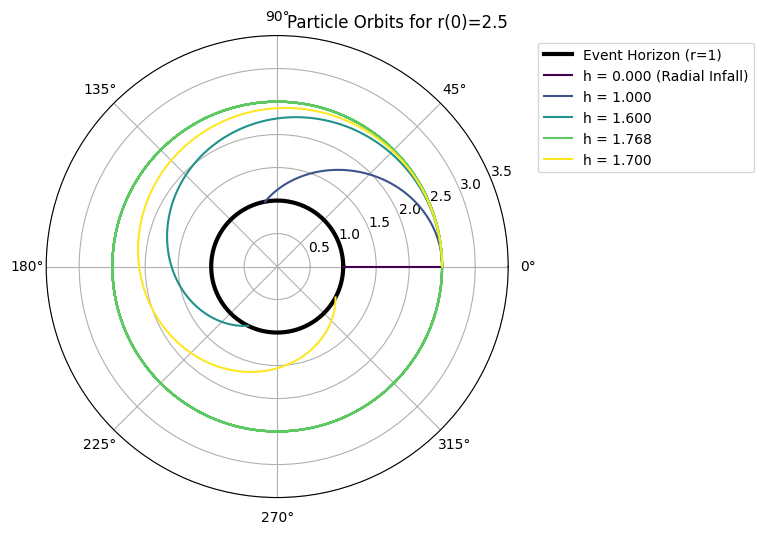

The critical angular momentum is approximately h_crit ≈ 1.7601
Proper time for radial infall (h=0): τ ≈ 5.4390


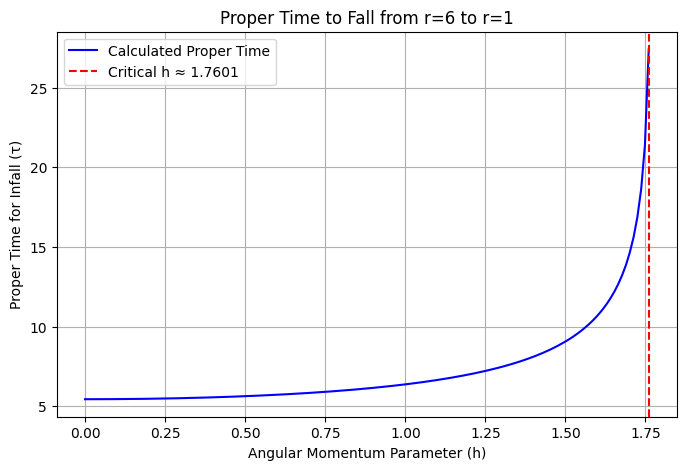

In [118]:
r_start = 2.5
h_circ = get_circular_h(r_start)
print(f"Angular momentum for a circular orbit at r={r_start}: h = {h_circ:.4f}\n")
h_to_plot = [0, 1.0, 1.6, h_circ, 1.7]
plot_orbits(r_start, h_to_plot)

h_critical = find_critical_h(r_start, search_range=(1.0, h_circ))
print(f"The critical angular momentum is approximately h_crit ≈ {h_critical:.4f}")

h_infall_range = np.linspace(0, h_critical, 150)
times = calculate_proper_time_for_infall(r_start, h_infall_range)
print(f"Proper time for radial infall (h=0): τ ≈ {times[0]:.4f}")
plot_proper_time(h_infall_range, times, h_critical)

The motion of a particle in a central potential can be simplified by introducing an effective potential $V_{\text{eff}}(r)$, which combines the gravitational potential with the angulra potential energy associated with the centrifugal barrier. The equation of motion in terms of the radial coordinate $r$ can be written as
\begin{equation}
    \left(\frac{dr}{d\tau}\right)^2 = E^2 - V_{\text{eff}}(r)^2,
\end{equation}
where for a massive particle
\begin{equation}
    V_{\text{eff}}(r)^2 = (1 - 1/r)(1 + h^2/r^2) = 1 - 1/r + h^2/r^2 - h^2/r^3.
\end{equation}
A circular orbit at a radius $r$ is possible if the particle sits at an extremum of the effective potential which corresponds to a net radial force of zero. We find these radii by taking the derivative of the potential with respect to $r$ and setting it to zero,
\begin{equation}
    \frac{dV_{\text{eff}}^2}{dr} = 1/r^2 - 2h^2/r^3 + 3h^2/r^4 = 0.
\end{equation}
Multiplying by $r^4$ gives
\begin{equation}
    r^2 - 2h^2r + 3h^2 = 0 \implies h^2 = \frac{r^2}{2r - 3}.
\end{equation}
This tells us that for $h$ to be a real number, we must have $2r - 3 > 0$, which means circular orbits are only possible for $r > 3/2$. For a circular orbit to be stable, the particle must be at a minimum of the effective potential. This requires the second derivative of the potential to be positive,
\begin{equation}
    \frac{d^2 V_{\text{eff}}^2}{dr^2} = -2/r^3 + 6h^2/r^4 - 12h^2/r^5 > 0.
\end{equation}
Multiplying by $r^5$ gives
\begin{equation}
    -2r^2 + 6h^2r - 12h^2 > 0,
\end{equation}
and we substituting the expression for $h^2$ yields
\begin{equation}
    -2r^2 + (6r^3 - 12r^2) / (2r - 3) > 0.
\end{equation}
Divide by $2r^2$,
\begin{equation}
    \frac{3r - 6}{2r - 3} > 1.
\end{equation}
Since we know $r > 3/2$, so $2r - 3 > 0$ is positive, we can multiply and preserve the inequality,
\begin{equation}
    3r - 6 > 2r - 3 \implies r > 3.
\end{equation}
We conclude that circular orbits can exist for any radius $r > 3/2$, however, stable circular orbits can only exist for $r > 3$.

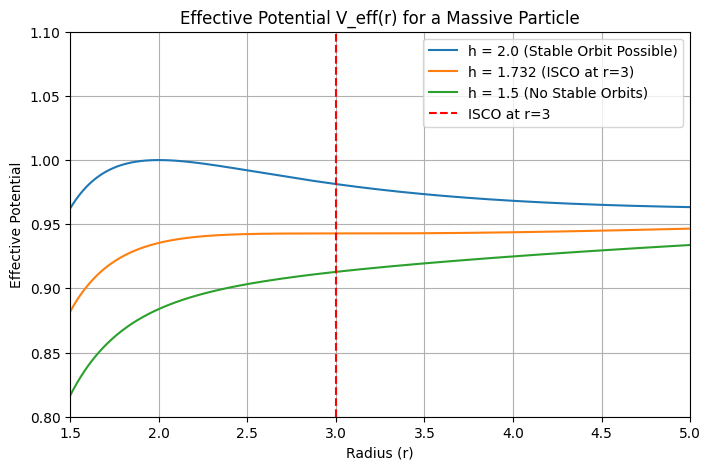

In [120]:
def effective_potential_sq(r, h_sq):
    '''
    Calculates the square of the effective potential.
    '''
    return (1 - 1/r) * (1 + h_sq / r**2)

r_vals = np.linspace(1.5, 5, 500)
h_isco = np.sqrt(3)

plt.figure(figsize=(8, 5))
plt.plot(r_vals, np.sqrt(effective_potential_sq(r_vals, 2.0**2)), label=f'h = 2.0 (Stable Orbit Possible)')
plt.plot(r_vals, np.sqrt(effective_potential_sq(r_vals, h_isco**2)), label=f'h = {h_isco:.3f} (ISCO at r=3)')
plt.plot(r_vals, np.sqrt(effective_potential_sq(r_vals, 1.5**2)), label=f'h = 1.5 (No Stable Orbits)')

plt.axvline(3, color='r', linestyle='--', label='ISCO at r=3')
plt.title('Effective Potential V_eff(r) for a Massive Particle')
plt.xlabel('Radius (r)')
plt.ylabel('Effective Potential')
plt.grid(True)
plt.legend()
plt.ylim(0.8, 1.1)
plt.xlim(1.5, 5)
plt.show()

Formulating the problem with respect to coordinate time $t$ instead of the angle $\phi$ changes the description of the motion but it does not change the underlying physics.

First, we would need to rederive the equations of motion but with respect to $t$. Instead of a single second-order equation for $\frac{d^2u}{d\phi^2}$, we would have a system of first-order equations for $r(t)$ and $\phi(t)$. These can be derived from the conserved quantities $E$ and $h$,
\begin{equation}
    \frac{d\phi}{dt} = \frac{h(1 - 1/r)}{Er^2} \\
    \frac{d^2r}{dt^2} = -\frac{1 - 1/r}{2r^2} + \frac{h^2(1 - 3/2r)}{r^3}.
\end{equation}
which combined with $\frac{dr}{dt} = v_r$ is a system of three first-order ODEs. The new outputs would be the angle over time and the velocity over time. The combined parametric polar plot could be animated to show the gravitational time dilation, showing the particle slowing down when observed from a distance.

The critical angular momentum for is a fundamental property of the spacetime geometry and the particle's energy. It is therefore independent of the coordinate system used to describe the motion. To find it, we would integrate the new system of equations over a long period of coordinate time $t$ and check whether the particle's radius $r(t)$ ever drops to $1$.

The proper time $\tau$ was calculated via a separate integral after the orbit shape was determined. With the dynamics $r(t)$ and $v_r(t)$ known, we could calculate the proper time by integrating $\frac{d\tau}{dt}$ along the solution. The relationship is
\begin{equation}
    \left( \frac{d\tau}{dt} \right)^2 = (1 - 1/r) - (1 - 1/r)^{-1} \left(\frac{dr}{dt}\right)^2 - r^2\left(\frac{d\phi}{dt}\right)^2.
\end{equation}
Similarly, this is a physical invariant.

Finally, the innermost stable circular orbit at $r=3$ is a fundamental, invariant feature of the Schwarzschild spacetime. Here, the analysis using the effective potential is independent of the choice of time coordinate an remains identical.